RDD on CN data

# Data sources

From x.com we download the raw data (including notes-00000.tsv)

On HPC we apply the scoring algorithsms, generating output in parquet format

We preprocess and merge these files using

    preprocess_dates.py
    merge_ratings_with_notes.py

# Environment

see requirements.txt or communitynotes2025-05-09.yml

# Libraries

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import calendar
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

# files and locations

userloc = '/home/tomstafford/Desktop/'
data_raw = userloc+'communitynotes/data2025raw/' # download from x.com
data_proc = userloc+'communitynotes/data2025proc/' # generating by CN code, run on HPC
data_post = userloc+'communitynotes/data2025post/' # post-processing, generated by our scripts

# TODO

add data prep instructions

## RDD
Our approach: check helpfulness scores of the first notes from each author in 2024. Check if they have written another note.

In [186]:
rated = pd.read_parquet(data_post+'rated_notes_compact.parquet', engine='auto')

len(rated) #1946619 for 2025 data

1946619

In [187]:
rated_2024 = rated[(rated.createdAt >= pd.Timestamp(2024, 1, 1)) &
                    (rated.createdAt < pd.Timestamp(2025, 1, 1))]

In [188]:
first_notes = rated_2024.groupby('noteAuthorParticipantId')\
    [['finalRatingStatus', 'numRatings', 'decidedBy','coreNoteIntercept', 'coreNoteInterceptMax']]\
    .first().reset_index()
have_another_note = rated_2024[rated_2024.groupby('noteAuthorParticipantId').cumcount() >= 2]\
    ['noteAuthorParticipantId'].to_list()
first_notes['if_written_again'] = first_notes['noteAuthorParticipantId'].isin(have_another_note)

In [189]:
# just focus on core model for now
first_notes = first_notes[first_notes['decidedBy'] == 'CoreModel (v1.1)']

<Axes: xlabel='if_written_again', ylabel='coreNoteIntercept'>

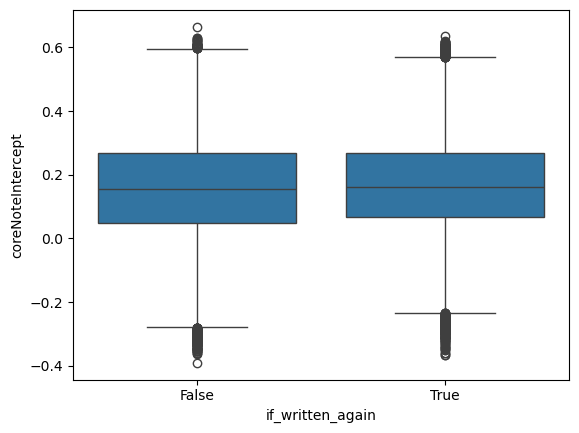

In [190]:
# boxplot of first notes' scores, divided by those followed (left) or not (right) by subsequent notes

sns.boxplot(y=first_notes['coreNoteIntercept'], x=first_notes['if_written_again'])

In [191]:
# RDD 

cutoff = 0.4 #threshold at which a note is rated as helpful
bandwidth = 0.05 #window around cutoff

# We fit a model allowing for different intercepts and slopes on either side of the cutoff.

running_variable = first_notes['coreNoteIntercept'] # x value, continuous input

# uncommment to run no higest ever score
#running_variable = first_notes['coreNoteInterceptMax'] # x value, continuous input

# Treatment = 1 if running_variable >= cutoff, else 0
treatment = np.where(running_variable >= cutoff, 1, 0)

#
outcome_variable = first_notes['if_written_again'].astype(int) # y value, binary output

# we can restrict the analysis to a window (bandwidth) around the cutoff.

mask = (running_variable > cutoff - bandwidth)  & (running_variable < cutoff + bandwidth)

data = pd.DataFrame({
    'running_variable': running_variable[mask],
    'treatment': treatment[mask],
    'outcome_variable': outcome_variable[mask]
})

# Center the running variable at the cutoff for easier interpretation of the intercept
data['running_variable_centered'] = data['running_variable'] - cutoff

print("Sample Data Head:")
print(data.head())
print(f"\nNumber of treated units: {data['treatment'].sum()}")
print(f"Number of control units: {data['treatment'].count() - data['treatment'].sum()}")


Sample Data Head:
    running_variable  treatment  outcome_variable  running_variable_centered
13          0.415720          1                 1                   0.015720
45          0.384220          0                 0                  -0.015780
48          0.365476          0                 1                  -0.034524
74          0.371758          0                 1                  -0.028242
98          0.424668          1                 0                   0.024668

Number of treated units: 4664
Number of control units: 5265


In [192]:
data.head()

,running_variable,treatment,outcome_variable,running_variable_centered
13,0.415720,1,1,0.015720
45,0.384220,0,0,-0.015780
48,0.365476,0,1,-0.034524
74,0.371758,0,1,-0.028242
98,0.424668,1,0,0.024668


In [193]:

rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'
rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


RDD Model Summary (using all data):
                            OLS Regression Results                            
Dep. Variable:       outcome_variable   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.628
Date:                Thu, 08 May 2025   Prob (F-statistic):           0.000752
Time:                        09:57:43   Log-Likelihood:                -7197.9
No. Observations:                9929   AIC:                         1.440e+04
Df Residuals:                    9925   BIC:                         1.443e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [194]:
# The coefficient for 'treatment' is the estimated effect at the cutoff.
estimated_effect = rdd_model.params['treatment']
print(f"\nEstimated Treatment Effect at the Cutoff: {estimated_effect:.4f}")

print("I think we can intepret this as a % change the chance of authoring again if published")

p_value_treatment = rdd_model.pvalues['treatment']
t_statistic_treatment = rdd_model.tvalues['treatment']
conf_int_treatment = rdd_model.conf_int().loc['treatment']

# print out p value and t-statistic for treatment
print(f"\nP-value for treatment: {p_value_treatment:.4f}")
print(f"T-statistic for treatment: {t_statistic_treatment:.4f}")
print(f"Confidence interval for treatment: " + str(conf_int_treatment))




Estimated Treatment Effect at the Cutoff: 0.0540
I think we can intepret this as a % change the chance of authoring again if published

P-value for treatment: 0.0071
T-statistic for treatment: 2.6923
Confidence interval for treatment: 0    0.014671
1    0.093237
Name: treatment, dtype: float64


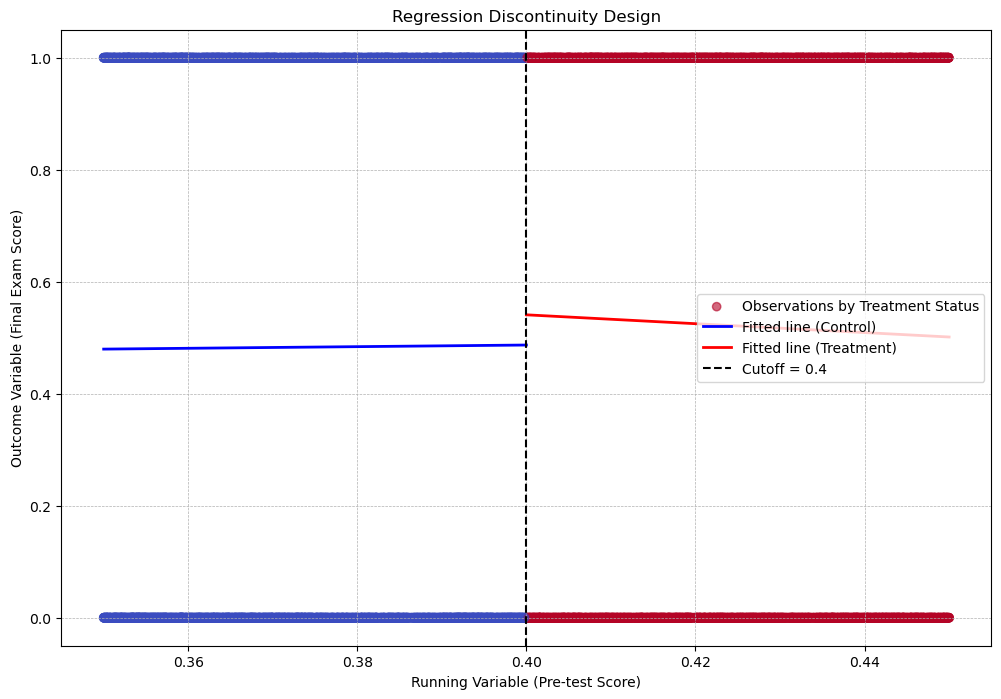

In [ ]:
# 3. Visualization
plt.figure(figsize=(12, 8))
plt.scatter(data['running_variable'], data['outcome_variable'],
            c=data['treatment'], cmap='coolwarm', alpha=0.6, label='Observations by Treatment Status')

# Plot regression lines for each side of the cutoff
# For values below the cutoff (treatment=0)
x_below = np.linspace(data['running_variable'].min(), cutoff, 100)
y_below = rdd_model.params['Intercept'] + rdd_model.params['running_variable_centered'] * (x_below - cutoff)

# For values above the cutoff (treatment=1)
x_above = np.linspace(cutoff, data['running_variable'].max(), 100)
y_above = (rdd_model.params['Intercept'] + rdd_model.params['treatment']) + \
          (rdd_model.params['running_variable_centered'] + rdd_model.params['running_variable_centered:treatment']) * (x_above - cutoff)

plt.plot(x_below, y_below, color='blue', linestyle='-', linewidth=2, label='Fitted line (Control)')
plt.plot(x_above, y_above, color='red', linestyle='-', linewidth=2, label='Fitted line (Treatment)')

plt.axvline(x=cutoff, color='black', linestyle='--', label=f'Cutoff = {cutoff}')
plt.xlabel('Running Variable (Final Note Score)')
plt.ylabel('Outcome Variable (Author progression)')
plt.title('Regression Discontinuity Design')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('plots/RDD.png',bbox_inches='tight',dpi=120)
plt.show()

